In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dataset_path = 'pothole_image_data'

images = []
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

images = np.array(images)

In [3]:
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

In [4]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)
    resized = cv2.resize(normalized, (128, 128))
    expanded = np.expand_dims(resized, axis=-1)
    return expanded

In [5]:
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, np.ones(len(X_train)), batch_size=32),
    validation_data=(X_test, np.ones(len(X_test))),
    epochs=50,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(X_test, np.ones(len(X_test)))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9174 - loss: 0.1426 - val_accuracy: 1.0000 - val_loss: 2.2105e-35
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1157e-37 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.

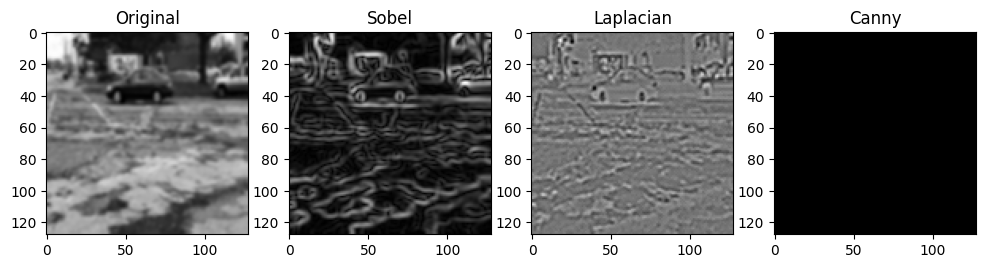

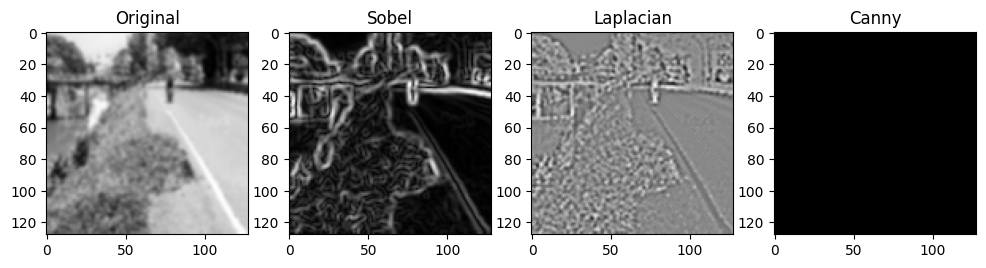

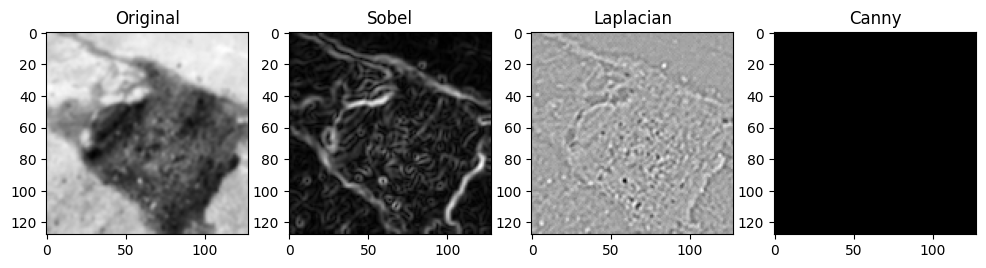

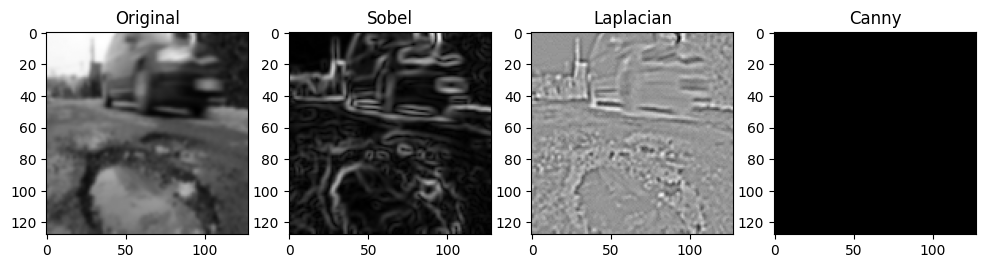

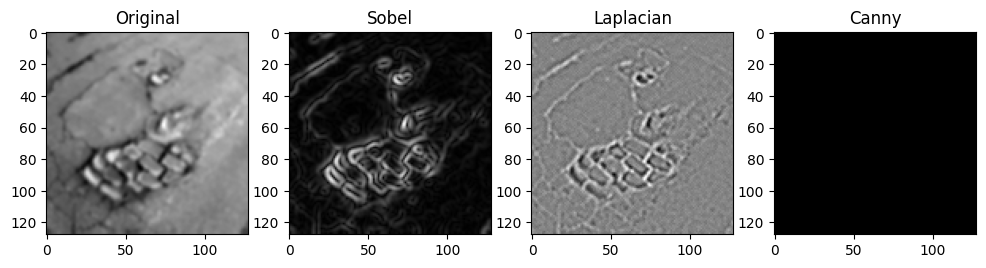

In [9]:
def apply_edge_detection(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    canny = cv2.Canny(np.uint8(img), 100, 200)
    return sobel_combined, laplacian, canny

for i in range(5):
    img = X_test[i].squeeze()
    sobel, laplacian, canny = apply_edge_detection(img)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.subplot(1, 4, 2)
    plt.imshow(sobel, cmap='gray')
    plt.title('Sobel')
    plt.subplot(1, 4, 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title('Laplacian')
    plt.subplot(1, 4, 4)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny')
    plt.show()